In [75]:
import operator
import pandas as pd
import sklearn.preprocessing
import sklearn.utils
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, accuracy_score
import sklearn.metrics as sklm
from sklearn.ensemble import RandomForestRegressor
#from hyperopt import hp, tpe, fmin, Trials
from functools import partial
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pickle
import os
from matplotlib import rc
import matplotlib
import pickle


In [76]:

fs = 10 # font size
fs_label = 10 # tick label size
fs_lgd = 10 # legend font size
ss = 20 # symbol size
ts = 3 # tick size
slw = 1 # symbol line width
framelw = 1 # line width of frame
lw = 2 # line width of the bar box
rc('axes', linewidth=framelw)
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.weight":"bold",
    "axes.labelweight":"bold",
    "font.size":fs,
    'pdf.fonttype':'truetype'
})
plt.rcParams['mathtext.fontset']='stix'

# Figure out which RACs are used in the ANN training in orginal database
def return_train_columns(df, cols_selected=False):
    keys = ['RACs']
    removed_columns = []
    if not cols_selected:
        return_columns = ['ligcharge', 'ox', 'spin']
        for col in df.columns:
            for key in keys:
                if key in col and 'init' not in col and 'misc' not in col:
                    if 'Zeff' not in col and '-O-' not in col:
                        return_columns.append(col)
    else:
        print("Using input columns.")
        return_columns = cols_selected
    print("inital: ", len(return_columns))
    df = df.dropna(subset=return_columns)
    thre = 1e-4
    final_cols = []
    for col in return_columns:
        std = np.std(df[col].values)
        if std < thre:
            removed_columns.append(col)
        else:
            final_cols.append(col)
    print("removed: ", removed_columns, len(removed_columns))
    print("feature_used:", final_cols, len(final_cols))
    return final_cols, df

def prepare_data(df, x_scaler, cols_selected=False):
    np.random.seed(0)
    cols_use, df = return_train_columns(df, cols_selected)
    X = np.array(df[cols_use].values)
    X_scaled = x_scaler.transform(X)
    return X_scaled, cols_use

def predict(model_filename, df, x_scaler_filename, y_scaler_filename, cols_selected=False):
    x_scaler = pickle.load(open(x_scaler_filename,'rb'))
    y_scaler = pickle.load(open(y_scaler_filename,'rb'))
    krr = pickle.load(open(model_filename,'rb'))
    X_scaled, cols_use =  prepare_data(df, x_scaler, cols_selected=cols_selected)
    y_pred_scaled = krr.predict(X_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    return y_pred


# Download Data and load data into Pandas

We will use the Supporting Information Data of Download the data from the following reference, 

* Fang Liu, Chenru Duan, and Heather J. Kulik
The Journal of Physical Chemistry Letters 2020 11 (19), 8067-8076
DOI: 10.1021/acs.jpclett.0c02288

The Supporting Information data is free of charge and opensource, execute next cell to download and unzip from following URL https://pubs.acs.org/doi/suppl/10.1021/acs.jpclett.0c02288/suppl_file/jz0c02288_si_002.zip

In [77]:
%%capture
!mkdir models
!wget  https://pubs.acs.org/doi/suppl/10.1021/acs.jpclett.0c02288/suppl_file/jz0c02288_si_002.zip -P models
!unzip models/jz0c02288_si_002.zip -d models

In [91]:
datapath = '' # path to your data folder
modelpath = os.path.join(datapath,'models')
filein=modelpath+'/Data/refined_datasets/refined_features.csv' # read in the CSV file containing the features. This file is just for example
df_features = pd.read_csv(filein)

filein2=modelpath+'/Data/refined_datasets/refined_properties.csv' # read in the CSV file containing the properties. This file is just for example
df_props = pd.read_csv(filein2)

## Take a look at the features

In [92]:
df_features.shape

(4865, 157)

In [93]:
df_features.head()

,id,name,set,ligcharge,ox,spin,RACs.D_lc-S-1-ax,RACs.D_lc-S-1-eq,RACs.D_lc-S-2-ax,RACs.D_lc-S-2-eq,...,RACs.mc-T-2-all,RACs.mc-T-3-all,RACs.mc-Z-0-all,RACs.mc-Z-1-all,RACs.mc-Z-2-all,RACs.mc-Z-3-all,RACs.mc-chi-0-all,RACs.mc-chi-1-all,RACs.mc-chi-2-all,RACs.mc-chi-3-all
0,0,metal_fe_ox_3_spin_6_ligstr_pyr_pyr_pyr_pyr_ca...,MD1,0,3,6,0.04,-0.04,0.00,0.72,...,156,192,676,1040,1664,1456,3.3489,31.5858,49.9224,69.540
1,1,metal_co_ox_2_spin_2_ligstr_misc_misc_misc_mis...,MD1,0,2,2,0.00,0.02,0.36,0.00,...,90,144,729,999,1296,1026,3.5344,29.6852,38.9160,37.036
2,2,metal_co_ox_3_spin_5_ligstr_water_water_water_...,MD1,0,3,5,0.72,0.72,0.00,0.00,...,72,0,729,1296,324,0,3.5344,38.8032,49.6320,0.000
3,3,metal_fe_ox_2_spin_1_ligstr_pyr_pyr_pyr_pyr_py...,MD1,0,2,1,-0.04,-0.04,0.72,0.72,...,216,288,676,1092,1872,2184,3.3489,33.3792,55.9980,104.310
4,4,metal_mn_ox_2_spin_2_ligstr_pyr_pyr_pyr_pyr_py...,MD1,0,2,2,-0.04,-0.04,0.72,0.72,...,216,288,625,1050,1800,2100,2.4025,28.2720,47.4300,88.350


## Take a look at the properties

In [94]:
df_props.shape

(4865, 24)

In [95]:
df_props.head()

,Unnamed: 0,ID,name,charge,ox,spin,natoms,liglist,ne_valence,energy (ha),...,I_ND,I_D,rND,I_ND_vn,FOD,FOD_vn,energeticHOMO (eV),energeticGap (eV),subset,set
0,0,0,metal_fe_ox_3_spin_6_ligstr_pyr_pyr_pyr_pyr_ca...,3,3,6,49,"[25, 25, 25, 25, 7, 7]",153,-1342.329042,...,0.777794,1.334297,0.368258,0.005084,1.823334,0.011917,-16.558125,1.480299,SRX,MD1
1,1,1,metal_co_ox_2_spin_2_ligstr_misc_misc_misc_mis...,2,2,2,38,"[18, 18, 18, 18, 25, 7]",119,-1037.237964,...,0.220155,0.973060,0.184505,0.001850,0.450361,0.003785,-12.876425,4.639540,SRX,MD1
2,2,2,metal_co_ox_3_spin_5_ligstr_water_water_water_...,3,3,5,19,"[28, 28, 28, 28, 28, 28]",62,-602.463874,...,0.375511,0.409059,0.478620,0.006057,0.871505,0.014057,-22.667080,2.606850,SRX,MD1
3,3,3,metal_fe_ox_2_spin_1_ligstr_pyr_pyr_pyr_pyr_py...,2,2,1,67,"[25, 25, 25, 25, 25, 25]",194,-1612.832027,...,0.487771,1.715463,0.221388,0.002514,0.996572,0.005137,-11.839671,5.175604,SRX,MD1
4,4,4,metal_mn_ox_2_spin_2_ligstr_pyr_pyr_pyr_pyr_py...,2,2,2,67,"[25, 25, 25, 25, 25, 25]",193,-1593.307398,...,0.557232,1.701161,0.246738,0.002887,1.161882,0.006020,-10.938975,3.891227,SRX,MD1


## Take a look at all the $r_{ND}$ diagnostic values

In [96]:
df_props['rND'].values

array([0.36825776, 0.18450546, 0.47861996, ..., 0.28135455, 0.34729125,
       0.46193074])

In [97]:
len(df_props['rND'].values)

4865

## Take a look at the HOMO-LUMO gap values

In [98]:
df_props['energeticGap (eV)'].values

array([1.48029907, 4.63954029, 2.6068502 , ..., 4.00551514, 2.84631035,
       2.69664776])

## Plot $r_{ND}$ vs HOMO-LUMO gap. Is there any correlation between them?

Text(0.5, 0, 'gap (eV)')

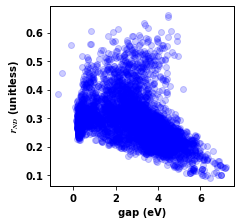

In [99]:
fig = plt.figure(figsize=(3.3,3.3))
gap = df_props['energeticGap (eV)'].values
rnd = df_props['rND'].values
plt.scatter(gap,rnd,edgecolors=None,c='b',alpha=0.2)
plt.ylabel('$r_{ND}$ (unitless)')
plt.xlabel('gap (eV)')

## Next we are going to try different ways to predict rND

# TODO: Predict $r_{ND}$ from HOMO-LUMO gap with linear regression

# Predict $r_{ND}$ from all molecular features (157) from the data set with linear regression

In [100]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [101]:
cols_use, df = return_train_columns(df_features, cols_selected=False)
X = np.array(df_features[cols_use].values)
y= df_props['rND'].values

inital:  154
removed:  [] 0
feature_used: ['ligcharge', 'ox', 'spin', 'RACs.D_lc-S-1-ax', 'RACs.D_lc-S-1-eq', 'RACs.D_lc-S-2-ax', 'RACs.D_lc-S-2-eq', 'RACs.D_lc-S-3-ax', 'RACs.D_lc-S-3-eq', 'RACs.D_lc-T-1-ax', 'RACs.D_lc-T-1-eq', 'RACs.D_lc-T-2-ax', 'RACs.D_lc-T-2-eq', 'RACs.D_lc-T-3-ax', 'RACs.D_lc-T-3-eq', 'RACs.D_lc-Z-1-ax', 'RACs.D_lc-Z-1-eq', 'RACs.D_lc-Z-2-ax', 'RACs.D_lc-Z-2-eq', 'RACs.D_lc-Z-3-ax', 'RACs.D_lc-Z-3-eq', 'RACs.D_lc-chi-1-ax', 'RACs.D_lc-chi-1-eq', 'RACs.D_lc-chi-2-ax', 'RACs.D_lc-chi-2-eq', 'RACs.D_lc-chi-3-ax', 'RACs.D_lc-chi-3-eq', 'RACs.D_mc-S-1-all', 'RACs.D_mc-S-2-all', 'RACs.D_mc-S-3-all', 'RACs.D_mc-T-1-all', 'RACs.D_mc-T-2-all', 'RACs.D_mc-T-3-all', 'RACs.D_mc-Z-1-all', 'RACs.D_mc-Z-2-all', 'RACs.D_mc-Z-3-all', 'RACs.D_mc-chi-1-all', 'RACs.D_mc-chi-2-all', 'RACs.D_mc-chi-3-all', 'RACs.f-I-0-all', 'RACs.f-I-0-ax', 'RACs.f-I-0-eq', 'RACs.f-I-1-all', 'RACs.f-I-1-ax', 'RACs.f-I-1-eq', 'RACs.f-I-2-all', 'RACs.f-I-2-ax', 'RACs.f-I-2-eq', 'RACs.f-I-3-all', 'RACs.

# TODO: Add some more markdown instructions where applicable

# split into train and test dataset

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [103]:
reg=linear_model.LinearRegression()

In [104]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [105]:
y_pred = reg.predict(X_test)

In [106]:
np.mean(np.abs(y_test-y_pred))

0.04515105586579527

Text(0.5, 0, '$r_{ND}$ (real)')

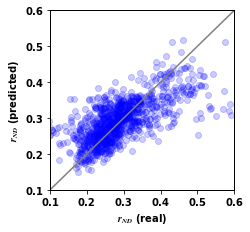

In [107]:

fig = plt.figure(figsize=(3.3,3.3))
plt.scatter(y_test,y_pred,edgecolors=None,c='b',alpha=0.2)
xmin=0.1; xmax=0.6
diag=np.linspace(xmin, xmax,100)
plt.plot(diag,diag, color='gray')
plt.xlim((xmin,xmax))
plt.ylim((xmin,xmax))
plt.ylabel('$r_{ND}$ (predicted)')
plt.xlabel('$r_{ND}$ (real)')

# Predcit $r_{ND}$ from selected molecule features (65 optimal features selected based on KRR performance) with linear regression

In [108]:
rfa_features = ["ligcharge","ox","spin","RACs.mc-Z-0-all","RACs.mc-S-0-all","RACs.f-chi-3-all","RACs.D_mc-Z-1-all","RACs.D_mc-S-1-all","RACs.f-Z-1-all","RACs.f-Z-0-all","RACs.f-chi-1-all","RACs.f-chi-0-all","RACs.f-chi-2-all","RACs.f-Z-2-all","RACs.D_mc-chi-2-all","RACs.mc-chi-2-all","RACs.mc-chi-1-all","RACs.f-S-0-all","RACs.f-S-2-all","RACs.D_mc-chi-1-all","RACs.mc-Z-1-all","RACs.f-S-1-all","RACs.f-S-3-all","RACs.f-Z-3-all","RACs.D_mc-S-2-all","RACs.D_mc-Z-2-all","RACs.f-I-2-all","RACs.f-I-0-all","RACs.mc-Z-2-all","RACs.f-chi-0-eq","RACs.f-I-3-all","RACs.f-T-3-all","RACs.lc-S-3-eq","RACs.mc-chi-3-all","RACs.f-T-0-all","RACs.D_mc-chi-3-all","RACs.D_mc-S-3-all","RACs.D_mc-Z-3-all","RACs.f-I-1-all","RACs.lc-chi-2-eq","RACs.D_lc-S-2-ax","RACs.mc-T-2-all","RACs.D_lc-S-2-eq","RACs.D_lc-chi-2-ax","RACs.D_lc-Z-2-ax","RACs.D_lc-Z-2-eq","RACs.D_lc-chi-2-eq","RACs.f-Z-3-eq","RACs.lc-T-3-eq","RACs.mc-I-3-all","RACs.f-Z-3-ax","RACs.D_lc-T-3-ax","RACs.mc-T-3-all","RACs.mc-chi-0-all","RACs.mc-S-1-all","RACs.f-T-2-all","RACs.f-T-1-all","RACs.mc-Z-3-all","RACs.f-T-3-ax","RACs.mc-S-2-all","RACs.f-Z-1-ax","RACs.mc-S-3-all","RACs.D_mc-T-3-all","RACs.f-Z-2-ax","RACs.f-T-3-eq"]

cols_use, df = return_train_columns(df_features, cols_selected=rfa_features)
X = np.array(df_features[cols_use].values)
y= df_props['rND'].values

Using input columns.
inital:  65
removed:  [] 0
feature_used: ['ligcharge', 'ox', 'spin', 'RACs.mc-Z-0-all', 'RACs.mc-S-0-all', 'RACs.f-chi-3-all', 'RACs.D_mc-Z-1-all', 'RACs.D_mc-S-1-all', 'RACs.f-Z-1-all', 'RACs.f-Z-0-all', 'RACs.f-chi-1-all', 'RACs.f-chi-0-all', 'RACs.f-chi-2-all', 'RACs.f-Z-2-all', 'RACs.D_mc-chi-2-all', 'RACs.mc-chi-2-all', 'RACs.mc-chi-1-all', 'RACs.f-S-0-all', 'RACs.f-S-2-all', 'RACs.D_mc-chi-1-all', 'RACs.mc-Z-1-all', 'RACs.f-S-1-all', 'RACs.f-S-3-all', 'RACs.f-Z-3-all', 'RACs.D_mc-S-2-all', 'RACs.D_mc-Z-2-all', 'RACs.f-I-2-all', 'RACs.f-I-0-all', 'RACs.mc-Z-2-all', 'RACs.f-chi-0-eq', 'RACs.f-I-3-all', 'RACs.f-T-3-all', 'RACs.lc-S-3-eq', 'RACs.mc-chi-3-all', 'RACs.f-T-0-all', 'RACs.D_mc-chi-3-all', 'RACs.D_mc-S-3-all', 'RACs.D_mc-Z-3-all', 'RACs.f-I-1-all', 'RACs.lc-chi-2-eq', 'RACs.D_lc-S-2-ax', 'RACs.mc-T-2-all', 'RACs.D_lc-S-2-eq', 'RACs.D_lc-chi-2-ax', 'RACs.D_lc-Z-2-ax', 'RACs.D_lc-Z-2-eq', 'RACs.D_lc-chi-2-eq', 'RACs.f-Z-3-eq', 'RACs.lc-T-3-eq', 'RACs.mc-

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg=linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [110]:
np.mean(np.abs(y_test-y_pred))

0.04610809527809965

Text(0.5, 0, '$r_{ND}$ (real)')

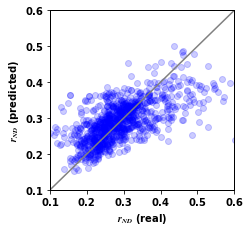

In [111]:


fig = plt.figure(figsize=(3.3,3.3))
plt.scatter(y_test,y_pred,edgecolors=None,c='b',alpha=0.2)
xmin=0.1; xmax=0.6
diag=np.linspace(xmin, xmax,100)
plt.plot(diag,diag, color='gray')
plt.xlim((xmin,xmax))
plt.ylim((xmin,xmax))
plt.ylabel('$r_{ND}$ (predicted)')
plt.xlabel('$r_{ND}$ (real)')

# Comparison with Kernel ridge regression (KRR) model to predict $r_{ND}$ from the RACS features 

In [112]:

modelfile = os.path.join(modelpath,'Data/models/KRR/MD2_rND_krr_model/MD2_rND_krr.pkl')
x_scaler_filename =  os.path.join(modelpath,'Data/models/KRR/MD2_rND_krr_model/x_scaler.pkl')
y_scaler_filename =  os.path.join(modelpath,'Data/models/KRR/MD2_rND_krr_model/y_scaler.pkl')
# Note we are not using all features. We are using the selected features verified to be optimal
rfa_features = ["ligcharge","ox","spin","RACs.mc-Z-0-all","RACs.mc-S-0-all","RACs.f-chi-3-all","RACs.D_mc-Z-1-all","RACs.D_mc-S-1-all","RACs.f-Z-1-all","RACs.f-Z-0-all","RACs.f-chi-1-all","RACs.f-chi-0-all","RACs.f-chi-2-all","RACs.f-Z-2-all","RACs.D_mc-chi-2-all","RACs.mc-chi-2-all","RACs.mc-chi-1-all","RACs.f-S-0-all","RACs.f-S-2-all","RACs.D_mc-chi-1-all","RACs.mc-Z-1-all","RACs.f-S-1-all","RACs.f-S-3-all","RACs.f-Z-3-all","RACs.D_mc-S-2-all","RACs.D_mc-Z-2-all","RACs.f-I-2-all","RACs.f-I-0-all","RACs.mc-Z-2-all","RACs.f-chi-0-eq","RACs.f-I-3-all","RACs.f-T-3-all","RACs.lc-S-3-eq","RACs.mc-chi-3-all","RACs.f-T-0-all","RACs.D_mc-chi-3-all","RACs.D_mc-S-3-all","RACs.D_mc-Z-3-all","RACs.f-I-1-all","RACs.lc-chi-2-eq","RACs.D_lc-S-2-ax","RACs.mc-T-2-all","RACs.D_lc-S-2-eq","RACs.D_lc-chi-2-ax","RACs.D_lc-Z-2-ax","RACs.D_lc-Z-2-eq","RACs.D_lc-chi-2-eq","RACs.f-Z-3-eq","RACs.lc-T-3-eq","RACs.mc-I-3-all","RACs.f-Z-3-ax","RACs.D_lc-T-3-ax","RACs.mc-T-3-all","RACs.mc-chi-0-all","RACs.mc-S-1-all","RACs.f-T-2-all","RACs.f-T-1-all","RACs.mc-Z-3-all","RACs.f-T-3-ax","RACs.mc-S-2-all","RACs.f-Z-1-ax","RACs.mc-S-3-all","RACs.D_mc-T-3-all","RACs.f-Z-2-ax","RACs.f-T-3-eq"]
y_predict = predict(modelfile, df_features, x_scaler_filename, y_scaler_filename,cols_selected=rfa_features)

/oasis/projects/nsf/mit181/eh22/install/conda/envs/dl2/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/oasis/projects/nsf/mit181/eh22/install/conda/envs/dl2/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator KernelRidge from version 0.20.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Using input columns.
inital:  65
removed:  [] 0
feature_used: ['ligcharge', 'ox', 'spin', 'RACs.mc-Z-0-all', 'RACs.mc-S-0-all', 'RACs.f-chi-3-all', 'RACs.D_mc-Z-1-all', 'RACs.D_mc-S-1-all', 'RACs.f-Z-1-all', 'RACs.f-Z-0-all', 'RACs.f-chi-1-all', 'RACs.f-chi-0-all', 'RACs.f-chi-2-all', 'RACs.f-Z-2-all', 'RACs.D_mc-chi-2-all', 'RACs.mc-chi-2-all', 'RACs.mc-chi-1-all', 'RACs.f-S-0-all', 'RACs.f-S-2-all', 'RACs.D_mc-chi-1-all', 'RACs.mc-Z-1-all', 'RACs.f-S-1-all', 'RACs.f-S-3-all', 'RACs.f-Z-3-all', 'RACs.D_mc-S-2-all', 'RACs.D_mc-Z-2-all', 'RACs.f-I-2-all', 'RACs.f-I-0-all', 'RACs.mc-Z-2-all', 'RACs.f-chi-0-eq', 'RACs.f-I-3-all', 'RACs.f-T-3-all', 'RACs.lc-S-3-eq', 'RACs.mc-chi-3-all', 'RACs.f-T-0-all', 'RACs.D_mc-chi-3-all', 'RACs.D_mc-S-3-all', 'RACs.D_mc-Z-3-all', 'RACs.f-I-1-all', 'RACs.lc-chi-2-eq', 'RACs.D_lc-S-2-ax', 'RACs.mc-T-2-all', 'RACs.D_lc-S-2-eq', 'RACs.D_lc-chi-2-ax', 'RACs.D_lc-Z-2-ax', 'RACs.D_lc-Z-2-eq', 'RACs.D_lc-chi-2-eq', 'RACs.f-Z-3-eq', 'RACs.lc-T-3-eq', 'RACs.mc-

In [113]:
np.mean(np.abs(y-y_predict))

0.08949331400244884

Text(0.5, 0, '$r_{ND}$ (real)')

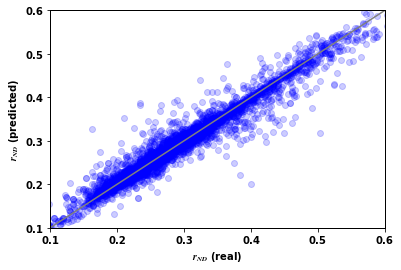

In [114]:

y = df_props['rND'].values
plt.scatter(y,y_predict,edgecolors=None,c='b',alpha=0.2)
xmin=0.1; xmax=0.6
diag=np.linspace(xmin, xmax,100)
plt.plot(diag,diag, color='gray')
plt.xlim((xmin,xmax))
plt.ylim((xmin,xmax))
plt.ylabel('$r_{ND}$ (predicted)')
plt.xlabel('$r_{ND}$ (real)')